In [1]:
!pip install datasets transformers torch evaluate accelerate

In [2]:
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from torch.utils.data import DataLoader
import torch
from tqdm.auto import tqdm

print("데이터셋과 토크나이저를 로드합니다...")
# Load dataset and tokenizer
dataset = load_dataset('blpeng/nsmc', split='train')
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
pad_token_id = tokenizer.pad_token_id
BATCH_SIZE = 32

# --- 시나리오 1: 정적 패딩 (Static Padding) ---
print("\n--- 시나리오 1: 정적 패딩 계산 중... ---")
total_static_padding = 0

def count_padding(example):
    tokenized_input = tokenizer(str(example['document']), truncation=True, padding='max_length', max_length=128)
    return {'padding_count': tokenized_input['input_ids'].count(pad_token_id)}

dataset_with_padding = dataset.map(count_padding, num_proc=4)
total_static_padding = sum(dataset_with_padding['padding_count'])

print(f"정적 패딩 방식의 총 패딩 토큰 수: {total_static_padding:,}")


# --- 시나리오 2: 버케팅 + 동적 패딩 (Bucketing + Dynamic Padding) ---
print("\n--- 시나리오 2: 버케팅 및 동적 패딩 계산 중... ---")
total_dynamic_padding = 0

# 1. Get lengths and sort dataset by length (simulating group_by_length)
print("데이터를 길이 순으로 정렬합니다 (버케팅 시뮬레이션)...")
lengths = [len(tokenizer.encode(str(doc), truncation=True, max_length=128)) for doc in tqdm(dataset['document'])]
sorted_indices = np.argsort(lengths)
sorted_dataset = dataset.select(sorted_indices)

# 2. Tokenize without padding
def tokenize_no_padding(examples):
    return tokenizer([str(doc) for doc in examples['document']], truncation=True, max_length=128)

tokenized_sorted_dataset = sorted_dataset.map(tokenize_no_padding, batched=True, num_proc=4)
tokenized_sorted_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# 3. Use DataLoader and DataCollator to simulate batching
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
dataloader = DataLoader(tokenized_sorted_dataset, batch_size=BATCH_SIZE, collate_fn=data_collator)

print("배치별로 동적 패딩을 계산합니다...")
for batch in tqdm(dataloader):
    total_tokens_in_batch = batch['input_ids'].numel()
    real_tokens_in_batch = torch.sum(batch['attention_mask'])
    padding_tokens_in_batch = total_tokens_in_batch - real_tokens_in_batch
    total_dynamic_padding += padding_tokens_in_batch.item()

print(f"버케팅+동적 패딩 방식의 총 패딩 토큰 수: {total_dynamic_padding:,}")
print("\n--- 계산 완료 ---")

# --- 최종 비교 ---
reduction = total_static_padding - total_dynamic_padding
reduction_percent = (reduction / total_static_padding) * 100 if total_static_padding > 0 else 0

print(f"\n패딩 토큰 감소량: {reduction:,} 개")
print(f"패딩 토큰 감소율: {reduction_percent:.2f}%")

데이터셋과 토크나이저를 로드합니다...


Repo card metadata block was not found. Setting CardData to empty.



--- 시나리오 1: 정적 패딩 계산 중... ---
정적 패딩 방식의 총 패딩 토큰 수: 15,858,683

--- 시나리오 2: 버케팅 및 동적 패딩 계산 중... ---
데이터를 길이 순으로 정렬합니다 (버케팅 시뮬레이션)...


  0%|          | 0/150000 [00:00<?, ?it/s]

배치별로 동적 패딩을 계산합니다...


  0%|          | 0/4688 [00:00<?, ?it/s]

버케팅+동적 패딩 방식의 총 패딩 토큰 수: 1,851

--- 계산 완료 ---

패딩 토큰 감소량: 15,856,832 개
패딩 토큰 감소율: 99.99%


/var/folders/14/wm3n_r1s01jfgw6n8j7pr4740000gn/T/ipykernel_34892/1785737087.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels([f'{int(tick)}' for tick in axes[0].get_yticks()])


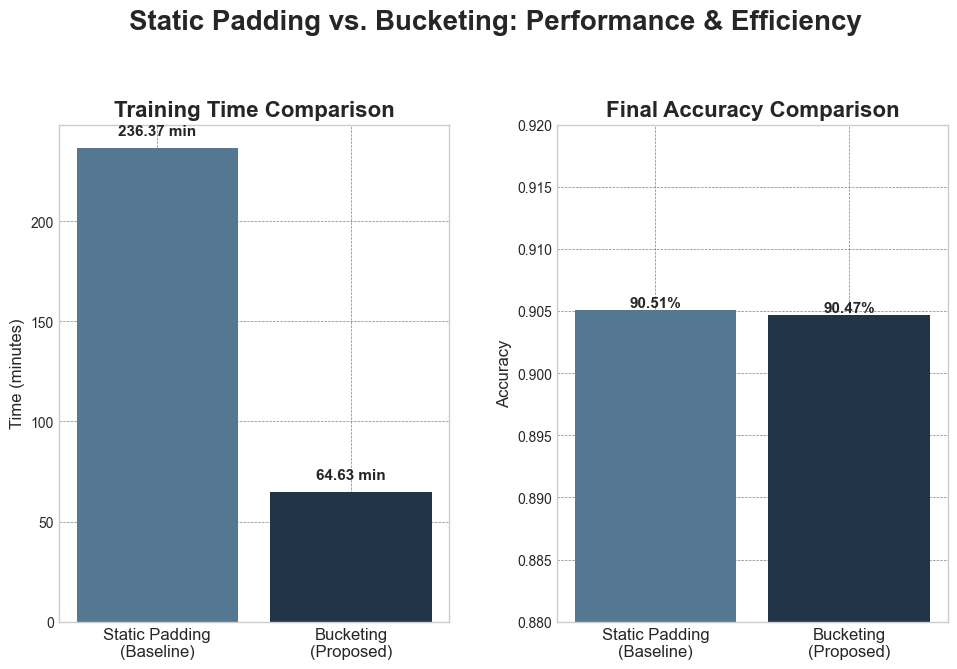

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data ---
methods = ['Static Padding\n(Baseline)', 'Bucketing\n(Proposed)']
train_times_sec = [14182.42, 3877.64] # Time in seconds
accuracies = [0.9051, 0.9047]

# --- Plotting ---
fig, axes = plt.subplots(1, 2, figsize=(10, 7))
plt.style.use('seaborn-v0_8-whitegrid')

# --- New Color Palette & Bar Width ---
colors = ['#547792', '#213448']
bar_width = 0.25 # 막대 두께를 0.3으로 더 줄임
x_positions = np.array([0.15, 0.45])

# 1. Training Time Comparison Plot
bars1 = axes[0].bar(x_positions, np.array(train_times_sec) / 60, color=colors, width=bar_width)
axes[0].set_title('Training Time Comparison', fontsize=16, fontweight='bold')
axes[0].set_xticks(x_positions)
axes[0].set_xticklabels(methods)
axes[0].set_ylabel('Time (minutes)', fontsize=12)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
axes[0].set_yticklabels([f'{int(tick)}' for tick in axes[0].get_yticks()])
for bar in bars1:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f} min', va='bottom', ha='center', fontsize=11, fontweight='bold', position=(bar.get_x()
+ bar.get_width()/2.0, yval+5))

# 2. Final Accuracy Comparison Plot
bars2 = axes[1].bar(x_positions, accuracies, color=colors, width=bar_width)
axes[1].set_title('Final Accuracy Comparison', fontsize=16, fontweight='bold')
axes[1].set_xticks(x_positions)
axes[1].set_xticklabels(methods)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_ylim(0.88, 0.92)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
for bar in bars2:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval*100:.2f}%', va='bottom', ha='center', fontsize=11, fontweight='bold')

# 전체 레이아웃 조정 및 저장
fig.suptitle('Static Padding vs. Bucketing: Performance & Efficiency', fontsize=20, fontweight='bold')
plt.subplots_adjust(wspace=20) # 그래프 사이의 좌우 간격(width space)을 조정
plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.savefig('comparison_graph_eng_v3.png', dpi=300)
plt.show()